In [27]:
print("Python běží!")

Python běží!


In [28]:
import sys

sys.path.append('../')
sys.path.append('../my_libs/')
sys.path.append('../my_libs/img/')

!{sys.executable} -m pip install -r ../../pip-dependencies.txt

Defaulting to user installation because normal site-packages is not writeable


In [29]:
import my_libs as ml
from my_libs.tools import *
from my_libs.fft import *
from my_libs.colors import *
from my_libs.img.processing import *

In [30]:
ml.tools.printf("Hello world!")

Hello world!

In [31]:
import skimage.feature

# Cvičení 8: slunečnice

Vytvořte  základní detektor  slunečnicových  květů  pomocí operace Laplacián  Gaussiánu  a  vyhodnoťte  jeho  úspěšnost  metrikami  precision  a recall. 

### Postup:
- Detekujte  tmavé  bloby  na  světlém  pozadí  pomocí  operace  **Laplacián Gaussiánu**. 
- Okolo  každého  blobu  vyřízněte  čtvercovou  oblast  o straně  přibližně `4*sigma.` 
- Oblast  převeďte  do  barevného  prostoru  HSV/HSL/...  a  ze  složky  hue vypočtěte histogram. 
- Porovnejte  histogram  se  shodně  připraveným  histogramem  vzorového obrázku `pvi_cv08_sunflower_template.jpg` pomocí Kullback-Lieblerovy divergence.  Pokud se ve vypočtených divergencích objeví  NaN,  přičtěte do porovnávaných histogramů malé číslo, např. 0.001,  aby  nedocházelo k logaritmování nebo dělení nulou. 
- Vhodně  stanoveným  prahem  divergence filtrujte oblasti, které nejsou slunečnicové květy. 
- Opakujte postup pro obrázky se slunečnicemi v archivu pvi_cv08.zip 
- Podobně  jako  ve  cvičení  č.  7  vypočtěte  hodnoty  **precision**  a  **recall**  při IoU=0.5. 
 
### Zdroje:
- https://scikit-image.org/docs/stable/api/skimage.feature.html 
- https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.entropy.html 

In [32]:
folder = 'data/'
IoU=0.5
#a = 4*sigma
sunflower_template_file = "pvi_cv08_sunflower_template.jpg"

## Načtení souborů

In [33]:
from my_libs.img import images
# reload img module
import importlib
importlib.reload(images)

# Find files
files = images.find(folder, "txt")  
files.sort()

# Filter images
picture_files = images.find(folder, "jpg")
picture_files.sort()

# remove template file
for i in range(len(picture_files)):
    if picture_files[i].find(sunflower_template_file) != -1:
        picture_files.pop(i)
        break

number_of_images = len(picture_files)
print("Number of images: ", number_of_images)


# Load images
imgs = images.load(picture_files)

Current working directory: /home/pytel/Skola/TUL-navazující_studium/3. semestr/PVI-Pocitacove_videni/cviceni/cv08, files: 
pvi_cv08_sunflowers4.txt
pvi_cv08_sunflowers1.txt
pvi_cv08_sunflowers2.txt
pvi_cv08_sunflowers3.txt
Current working directory: /home/pytel/Skola/TUL-navazující_studium/3. semestr/PVI-Pocitacove_videni/cviceni/cv08, files: 
pvi_cv08_sunflowers2.jpg
pvi_cv08_sunflowers3.jpg
pvi_cv08_sunflowers4.jpg
pvi_cv08_sunflower_template.jpg
pvi_cv08_sunflowers1.jpg
Number of images:  4


In [34]:
def file_to_xy_box(file_path):
    """ 

    Returns:
        list of tuples ((x1, y1), (x2, y2))
    """
    NUMBER_OF_VALUES = 4
    def parse_line_to_ints(line):
        values = line.split()
        return [int(value) for value in values]

    def is_text_file(file_path):
        return file_path.endswith('.txt')
    
    if not is_text_file(file_path):
        raise ValueError("File is not text file")
    
    lines = []
    with open(file_path, 'r') as file:
        lines = file.readlines()
    
    for line in lines:
        numbers =  parse_line_to_ints(line)
        if len(numbers) != NUMBER_OF_VALUES:
            raise ValueError("Line has not 4 numbers")
        yield ((numbers[0], numbers[1]), (numbers[2], numbers[3]))
        

def load_files_to_dict(files):
    dict_files_boxes = {}
    for file in files:
        dict_files_boxes[file] = list(file_to_xy_box(file))
    return dict_files_boxes

# nacteni textovych souboru
dict_files_boxes = load_files_to_dict(files)

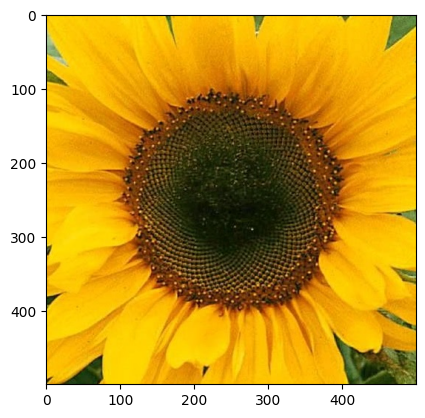

In [35]:
# Load template
img_template_bgr = cv2.imread(folder + sunflower_template_file)
img_template = cv2.cvtColor(img_template_bgr, cv2.COLOR_BGR2RGB)


# visualize template
plt.imshow(img_template)

## Detekujte  tmavé  bloby  na  světlém  pozadí  pomocí  operace  Laplacián Gaussiánu.

In [36]:
def genereta_sizes(min, max):
    """ 
    sigma_k = sigma_0 * s^k 
    s = sqrt(2)
    """
    # use yeald
    s = np.sqrt(2)
    sigma_0 = min
    sigma_k = sigma_0
    while sigma_k < max:
        yield sigma_k
        sigma_k *= s

# test
sigma_min = 1
sigma_max = 50
sizes = list(genereta_sizes(sigma_min, sigma_max))

for i in range(len(sizes)):
    sizes[i] = float(round(sizes[i], 2))

print(sizes)

[1.0, 1.41, 2.0, 2.83, 4.0, 5.66, 8.0, 11.31, 16.0, 22.63, 32.0, 45.25]


2.0
2.83
4.0
5.66
8.0
11.31
16.0
22.63
32.0
45.25
64.0
90.51


/tmp/ipykernel_18954/1146756611.py:46: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure()


<Figure size 640x480 with 0 Axes>

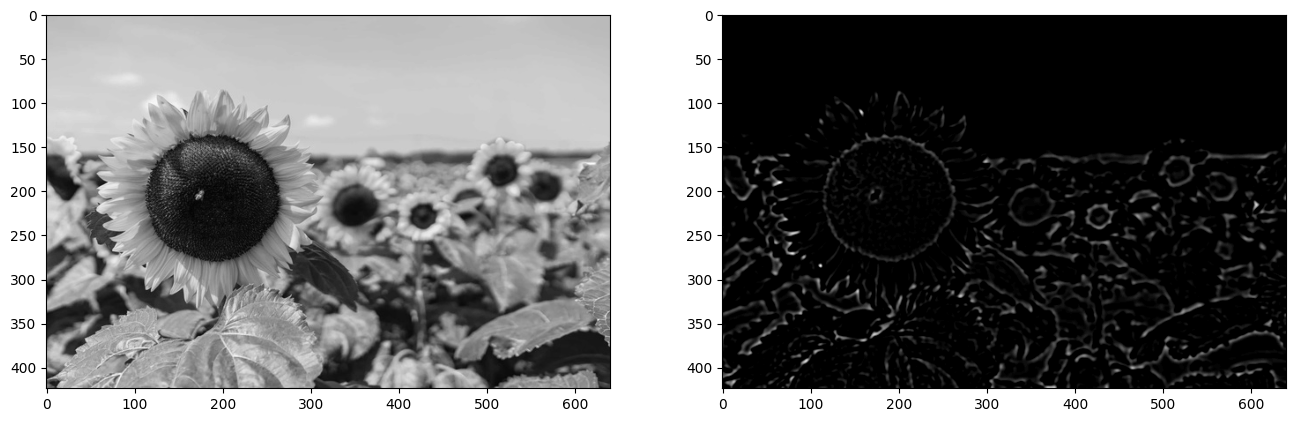

<Figure size 640x480 with 0 Axes>

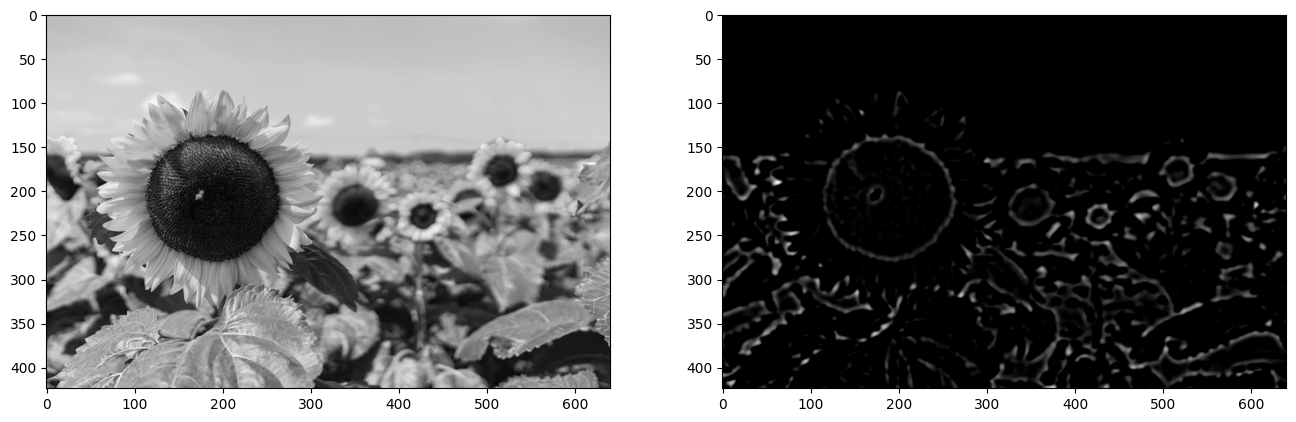

<Figure size 640x480 with 0 Axes>

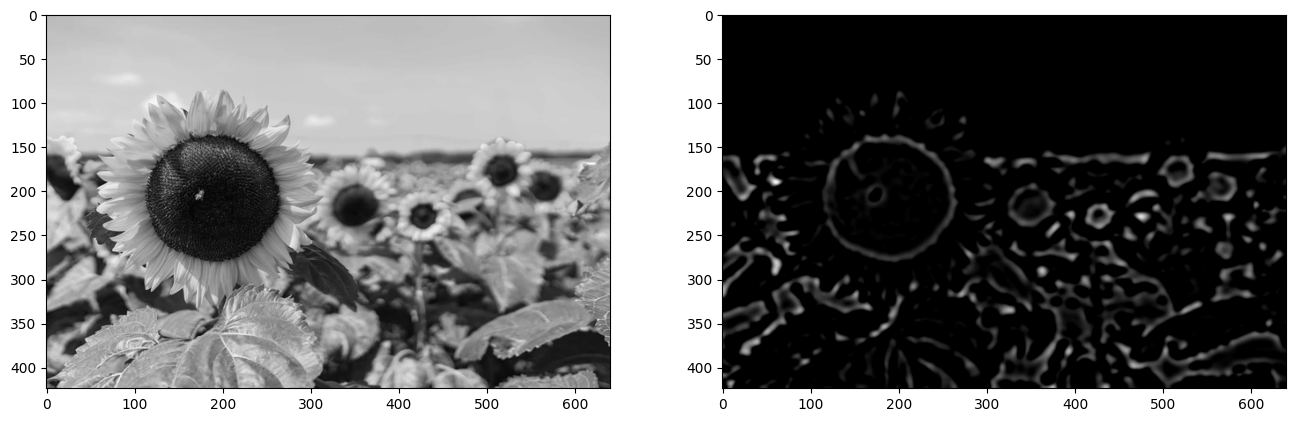

<Figure size 640x480 with 0 Axes>

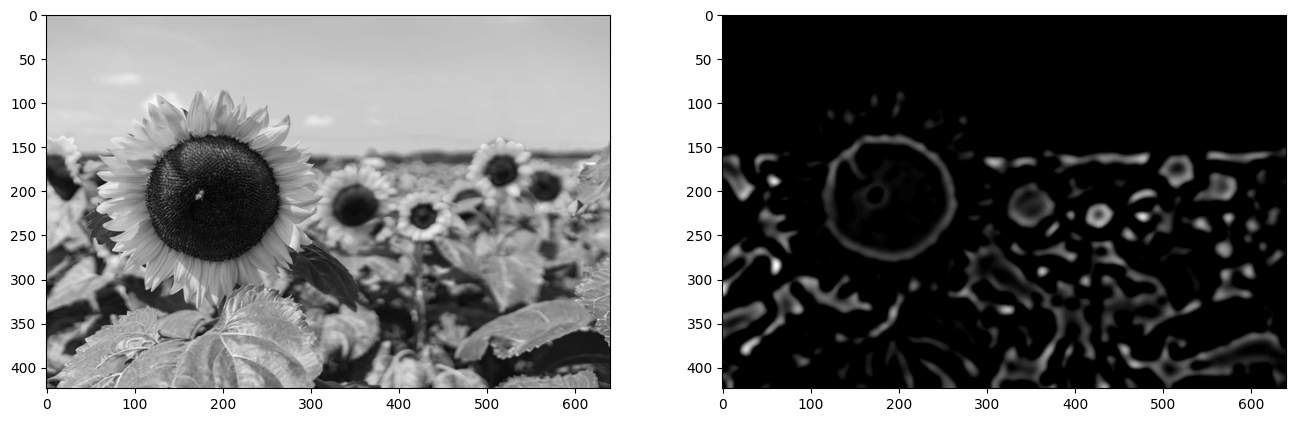

<Figure size 640x480 with 0 Axes>

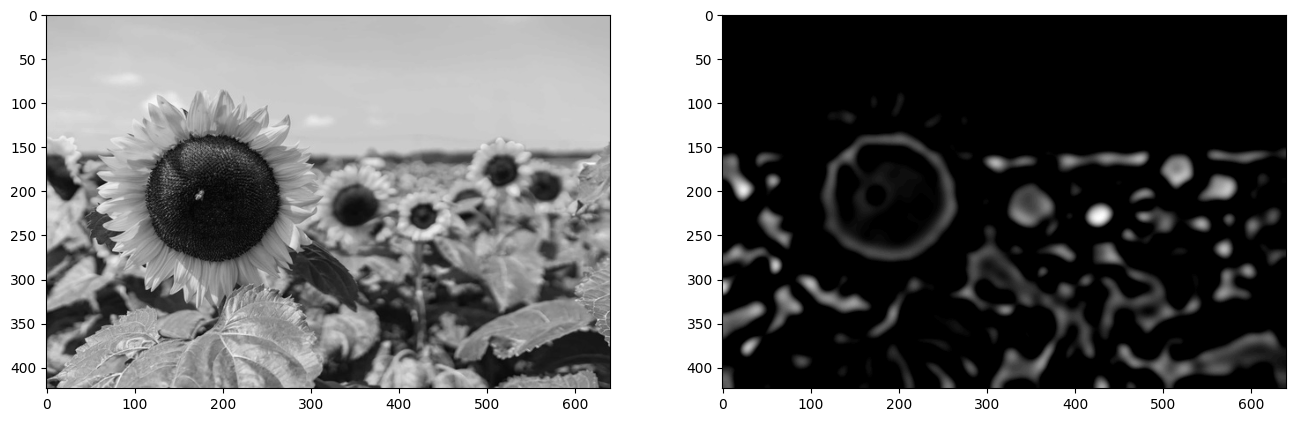

<Figure size 640x480 with 0 Axes>

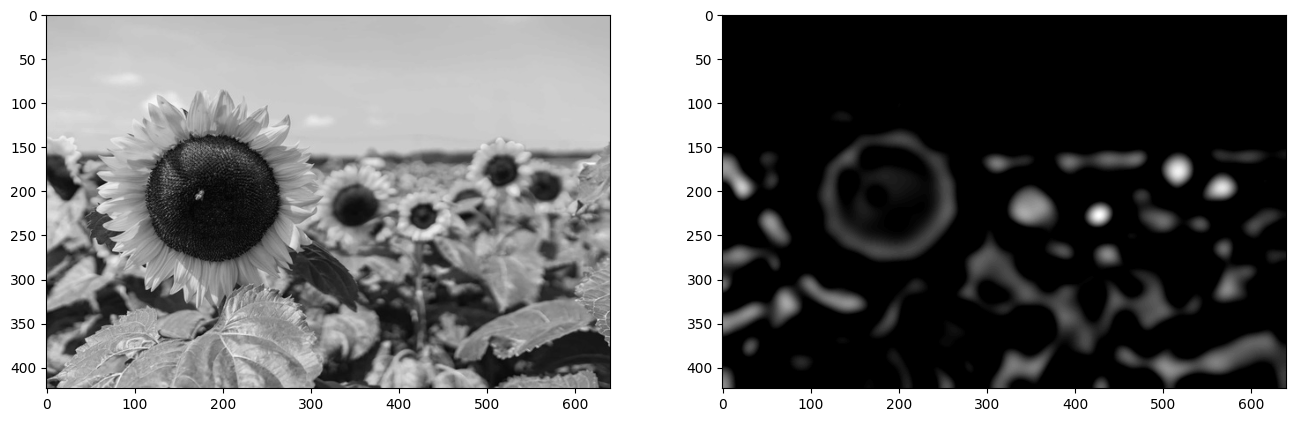

<Figure size 640x480 with 0 Axes>

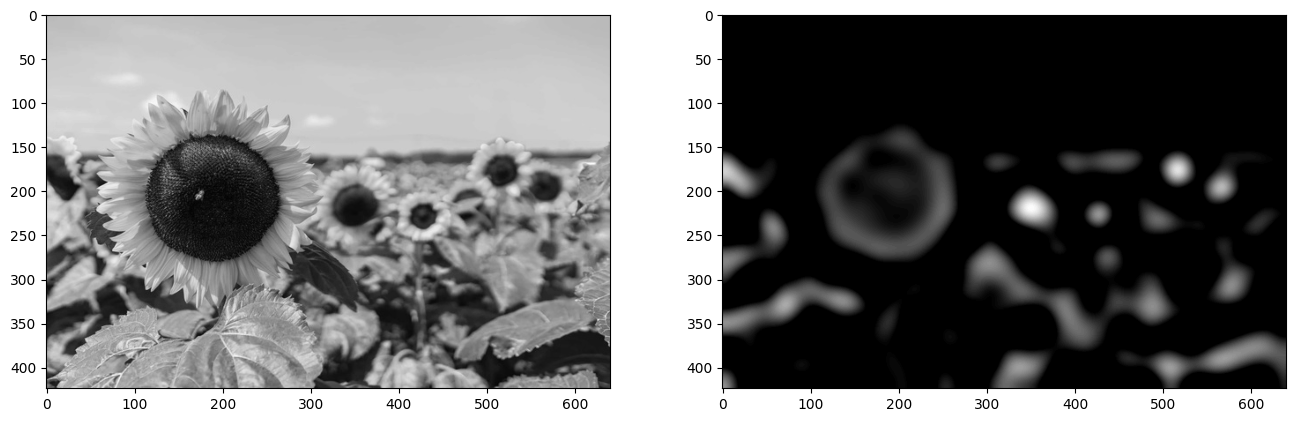

<Figure size 640x480 with 0 Axes>

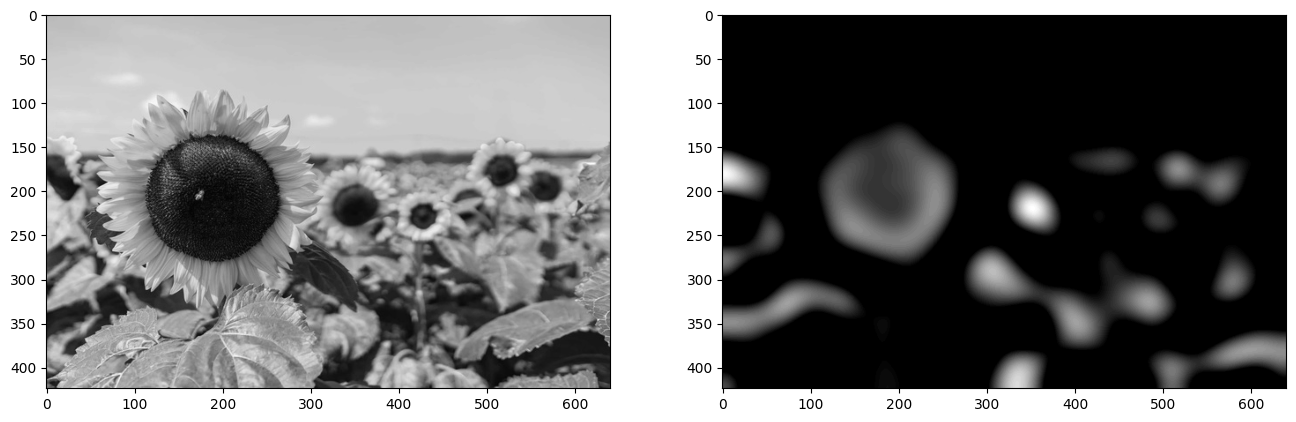

<Figure size 640x480 with 0 Axes>

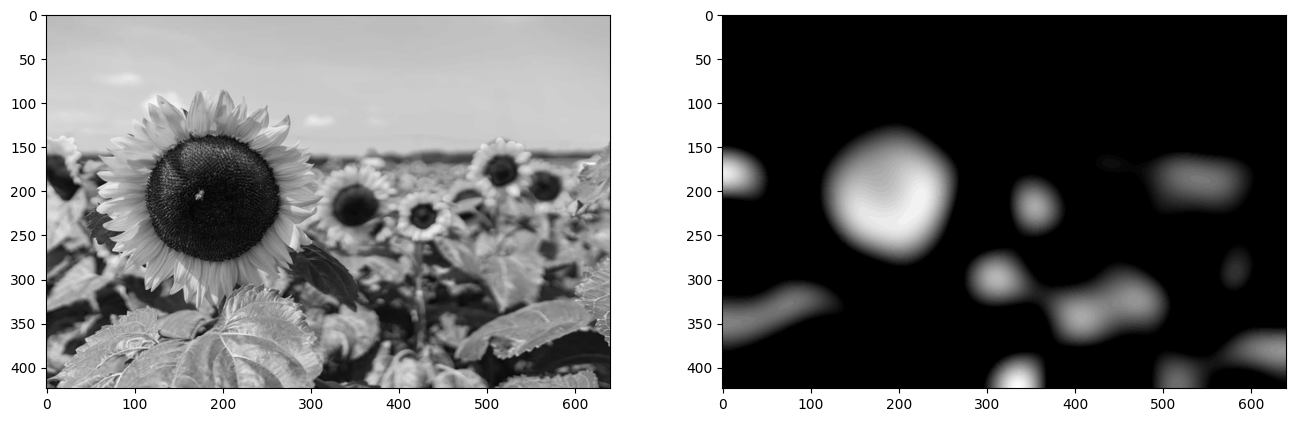

<Figure size 640x480 with 0 Axes>

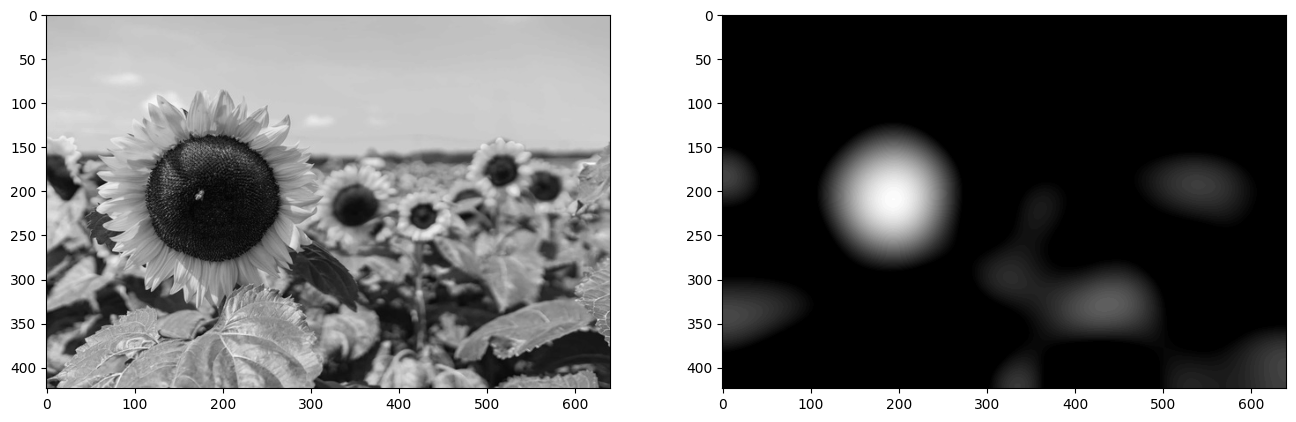

<Figure size 640x480 with 0 Axes>

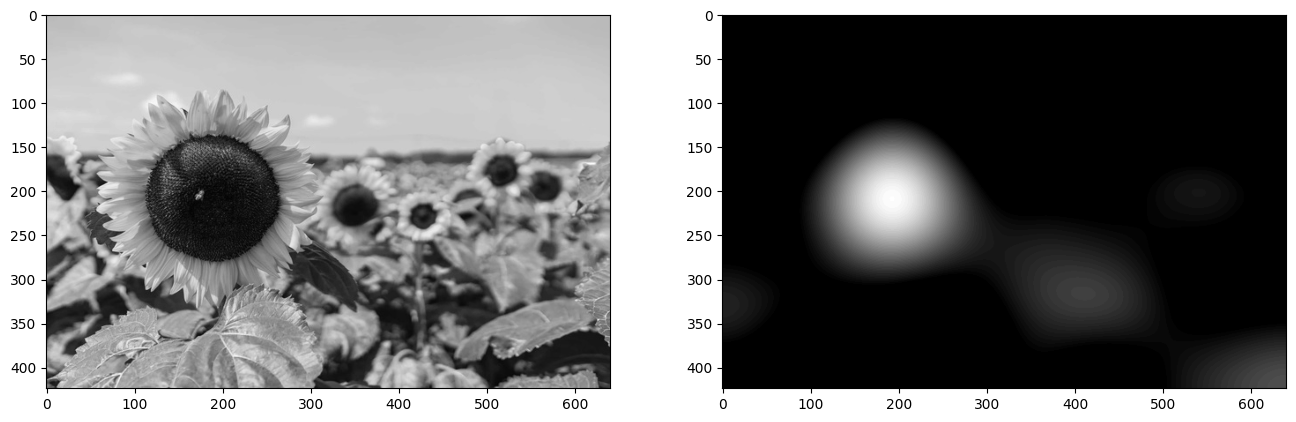

<Figure size 640x480 with 0 Axes>

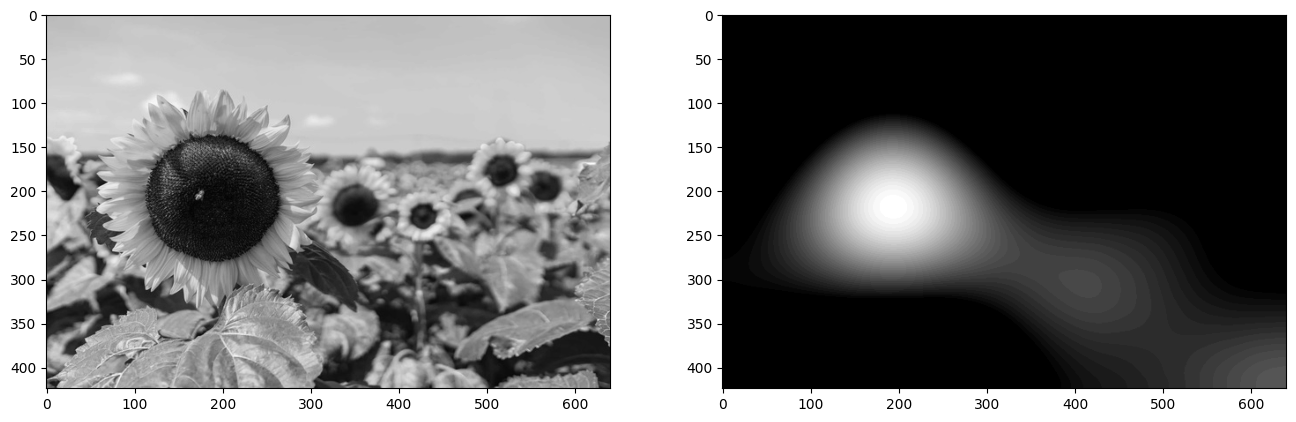

In [37]:
# Detekujte  tmavé  bloby  na  světlém  pozadí  pomocí  operace  Laplacián Gaussiánu

def LoG_filter(image, sigma, size=None):
    """
    Apply Laplacian of Gaussian filter to an image.

    Zdroj:
    - https://medium.com/@rajilini/laplacian-of-gaussian-filter-log-for-image-processing-c2d1659d5d2
    
    Parameters:
        image (ndarray): Input image.
        sigma (float): Standard deviation for Gaussian kernel.
        size (int, optional): Size of the Gaussian kernel. If None, it will be calculated.
        
    Returns:
        ndarray: Image after applying LoG filter.
    """
    # Generate LoG kernel
    if size is None:
        size = int(6 * sigma + 1) if sigma >= 1 else 7

    if size % 2 == 0:
        size += 1

    x, y = np.meshgrid(np.arange(-size//2+1, size//2+1), np.arange(-size//2+1, size//2+1))
    kernel = -(1/(np.pi * sigma**4)) * (1 - ((x**2 + y**2) / (2 * sigma**2))) * np.exp(-(x**2 + y**2) / (2 * sigma**2))
    kernel = kernel / np.sum(np.abs(kernel))

    # Perform convolution using OpenCV filter2D
    result = cv2.filter2D(image, -1, kernel)

    return result

# test
image = imgs[0]
sigma_min = 2
sigma_max = int(min(image.shape[0], image.shape[1])/4)
for sigma in genereta_sizes(sigma_min, sigma_max):
    sigma = float(round(sigma, 2))
    print(sigma)
    
    img_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    img_template_log = LoG_filter(img_gray, sigma)

    # visualize
    plt.figure()
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.imshow(img_gray, cmap='gray')
    plt.subplot(1, 2, 2)
    plt.imshow(img_template_log, cmap='gray')

## Rozpoznání blobů

60


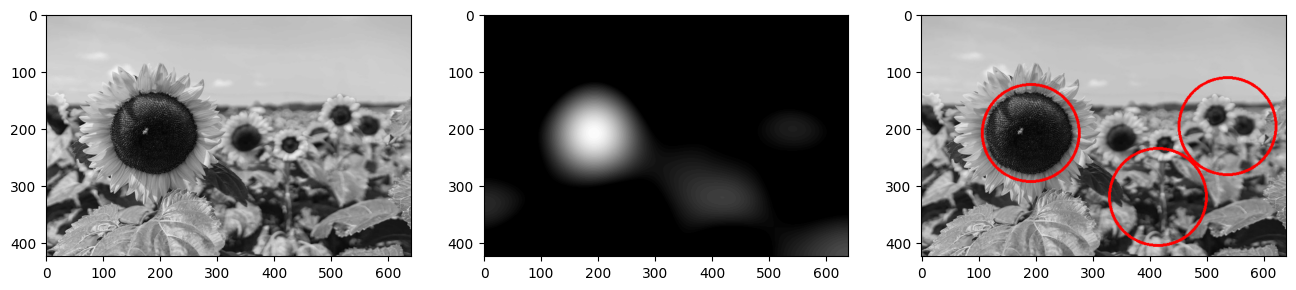

In [56]:
sigma = 60
num_peaks = 100
print(sigma)

# Apply LoG filter
img_gray = cv2.cvtColor(imgs[0], cv2.COLOR_RGB2GRAY)
img_log = LoG_filter(img_gray, sigma)

# Find local maxima
min_distance = int(sigma)
maxima = skimage.feature.peak_local_max(img_log, min_distance=min_distance, threshold_abs=0.01, num_peaks=num_peaks)

def sigma_to_radius(sigma):
    radius = int(np.round(sigma * np.sqrt(2)))
    return radius

# Create list of blobs
blobs = []
for y, x in maxima:
    blobs.append((x, y, sigma))

# Draw blobs
img_blobs = img_gray.copy()
# to color
img_blobs = cv2.cvtColor(img_blobs, cv2.COLOR_GRAY2RGB)
color = (255, 0, 0)
size = 3
for x, y, sigma in blobs:
    r = sigma_to_radius(sigma)
    cv2.circle(img_blobs, (x, y), r, color, size)

# visualize
plt.figure(figsize=(16, 8))
plt.subplot(1, 3, 1)
plt.imshow(img_gray, cmap='gray')
plt.subplot(1, 3, 2)
plt.imshow(img_log, cmap='gray')
plt.subplot(1, 3, 3)
plt.imshow(img_blobs)
plt.show()

## Převod do HSV a výpočet histogramu

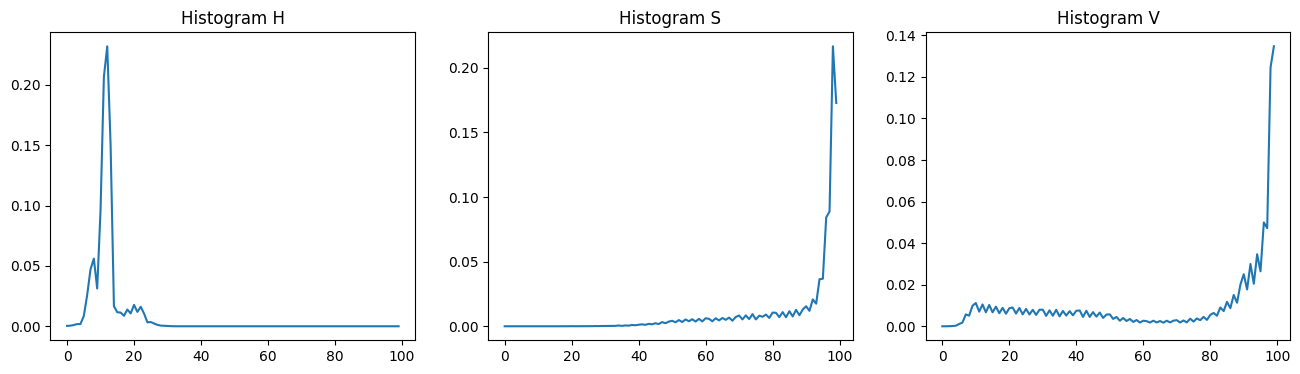

In [49]:
# prevod do HSV
img_template_hsv = cv2.cvtColor(img_template, cv2.COLOR_RGB2HSV)
H, S, V = cv2.split(img_template_hsv)

# vypocet histogramu
HIST_LEN = 100
img_template_hist_H = cv2.calcHist([H], [0], None, [HIST_LEN], [0, 180])
img_template_hist_S = cv2.calcHist([S], [0], None, [HIST_LEN], [0, 255])
img_template_hist_V = cv2.calcHist([V], [0], None, [HIST_LEN], [0, 255])

# normalizace histogramu
img_template_hist_H = img_template_hist_H / np.sum(img_template_hist_H)
img_template_hist_S = img_template_hist_S / np.sum(img_template_hist_S)
img_template_hist_V = img_template_hist_V / np.sum(img_template_hist_V)

# vizualizace
plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
plt.plot(img_template_hist_H)
plt.title("Histogram H")
plt.subplot(1, 3, 2)
plt.plot(img_template_hist_S)
plt.title("Histogram S")
plt.subplot(1, 3, 3)
plt.plot(img_template_hist_V)
plt.title("Histogram V")
plt.show()

## Porovnání histogramu s histogramem vzorového obrázku
- Kullback-Lieblerovy divergence

2.292658
1.1890018
7.0846615


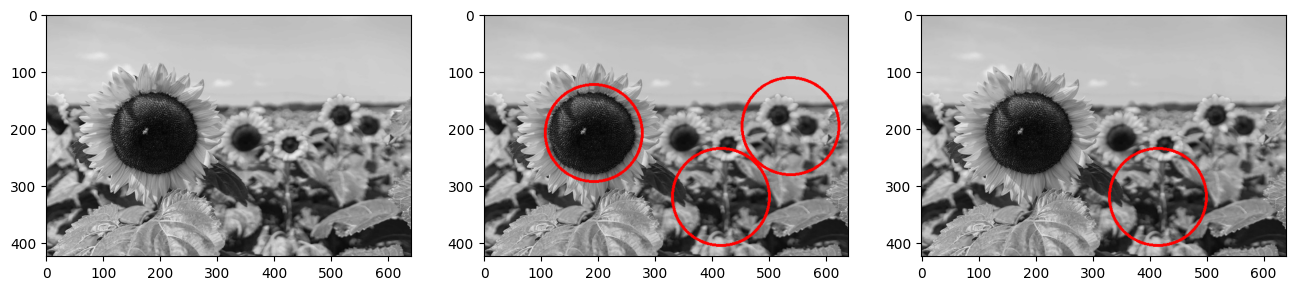

In [ ]:
# Kullback-Lieblerovy divergence
import scipy.special

# suma kvadratu odchylek
def sum_of_squares(hist1, hist2):
    return np.sum((hist1 - hist2)**2)

def KL_divergence(hist1, hist2, epsilon=1e-10):
    """
    Calculate Kullback-Liebler divergence between two histograms.
    
    Parameters:
        hist1 (ndarray): First histogram.
        hist2 (ndarray): Second histogram.
        
    Returns:
        float: Kullback-Liebler divergence.
    """
    # normalizace
    hist1 = hist1 / np.sum(hist1)
    hist2 = hist2 / np.sum(hist2)
    kl_div = hist1 * np.log((hist1 + epsilon) / (hist2 + epsilon))
    return np.sum()

def sigma_to_side(sigma):
    return 4*sigma

def convert_blob_to_box(blob):
    x, y, sigma = blob
    side = sigma_to_side(sigma)
    x1 = int(x-side/2)
    x2 = int(x+side/2)
    y1 = int(y-side/2)
    y2 = int(y+side/2)

    x1 = x1 if x1 > 0 else 0
    y1 = y1 if y1 > 0 else 0
    return ((x1, y1), (x2, y2))

def compare_blob_and_etalon(img, blob:tuple, etalon_H:np.ndarray) -> float:
    """
    Compare blob with etalon.
    
    Parameters:
        img (ndarray): Input image.
        blob (tuple): Blob (x, y, r).
        etalon_H (ndarray): Etalon histogram.
    
    Returns:
        float: sum(Kullback-Liebler divergence)
    """
    box = convert_blob_to_box(blob)
    x1, y1 = box[0]
    x2, y2 = box[1]
    img_blob = img[y1:y2, x1:x2]
    #print(img_blob.shape)
    img_blob_hsv = cv2.cvtColor(img_blob, cv2.COLOR_RGB2HSV)
    H, _, _ = cv2.split(img_blob_hsv)
    hist_H = cv2.calcHist([H], [0], None, [HIST_LEN], [0, 180])
    return KL_divergence(hist_H, etalon_H)
    #return np.sum(scipy.special.kl_div(hist_H, etalon_H))

def remove_unfiting_blobs_with_KL_div(img, blobs, img_template_hist_H, divergence_threshold:float=1) -> tuple:
    """ 
    Remove blobs with divergence higher than divergence_threshold.
    """
    blobs_filtered = []
    for blob in blobs:
        divergence = compare_blob_and_etalon(img, blob, img_template_hist_H)
        print(divergence)
        if divergence < divergence_threshold:
            blobs_filtered.append(blob)
    return blobs_filtered

# test

# Draw blobs
img_blobs = img_gray.copy()
img_filtered_blobs = img_gray.copy()
# to color
img_blobs = cv2.cvtColor(img_blobs, cv2.COLOR_GRAY2RGB)
img_filtered_blobs = cv2.cvtColor(img_filtered_blobs, cv2.COLOR_GRAY2RGB)
color = (255, 0, 0)
radius = 3

# Draw blobs
for x, y, sigma in blobs:
    r = sigma_to_radius(sigma)
    cv2.circle(img_blobs, (x, y), r, color, radius)

# Filter blobs
divergence_threshold = 1.2
blobs_filtered = remove_unfiting_blobs_with_KL_div(imgs[0], blobs, img_template_hist_H, divergence_threshold)

# Draw filtered blobs
for x, y, sigma in blobs_filtered:
    r = sigma_to_radius(sigma)
    cv2.circle(img_filtered_blobs, (x, y), r, color, radius)

# visualize
plt.figure(figsize=(16, 8))
plt.subplot(1, 3, 1)
plt.imshow(img_gray, cmap='gray')
plt.subplot(1, 3, 2)
plt.imshow(img_blobs)
plt.subplot(1, 3, 3)
plt.imshow(img_filtered_blobs)

plt.show()

## Area of Overlapping Rectangles
The area of any rectangle can be calculated using the formula: (x_distance) * (y_distance). Since the rectangles may overlap, we can use Inclusion Exclusion principle to calculate the area as follows:


Total Area = Area of Rectangle1 + Area of Rectangle2 – Intersecting area of both the rectangles 


For Rectangle1:
```Python
x_distance = abs(L1.x – R1.x) 
y_distance = abs(L1.y – R1.y) 
Area of Rectangle1 = x_distance * y_distance
```

For Rectangle2:
```Python
x_distance = abs(L2.x – R2.x) 
y_distance = abs(L2.y – R2.y)
Area of Rectangle2 = x_distance * y_distance
```

For area of overlapping Rectangle:
```Python
x_distance = min(R1.x, R2.x) – max(L1.x, L2.x) 
y_distance = min(R1.y, R2.y) – max(L1.y, L2.y)
Area of overlapping rectange = x_distance * y_distance
```
If the x_distance or y_distance is negative, then the two rectangles do not intersect. In that case, overlapping area is 0.

In [41]:
DEBUG = False
def calculate_are_of_intersection(box1:tuple, box2:tuple) -> float:
    """
    ((x1, y1), (x2, y2))
    """
    LEFT = 0
    RIGHT = 1
    X = 0
    Y = 1
    
    def area(box):
        dx = box[RIGHT][X] - box[LEFT][X]
        dy = box[RIGHT][Y] - box[LEFT][Y]
        if dx < 0 or dy < 0:
            return 0
        return dx * dy
    
    # Intersection
    def intersection(box1, box2):
        left = (max(box1[LEFT][X], box2[LEFT][X]), max(box1[LEFT][Y], box2[LEFT][Y]))
        right = (min(box1[RIGHT][X], box2[RIGHT][X]), min(box1[RIGHT][Y], box2[RIGHT][Y]))
        return (left, right)
    
    intersection_area = area(intersection(box1, box2))
    union_area = area(box1) + area(box2) - intersection_area

    if DEBUG:
        print()
        print("Box" + str(box1), "Box" + str(box2))
        print(" + box1 area: ", area(box1))
        print(" + box2 area: ", area(box2))
        print("Intersection Box: ", intersection(box1, box2))
        print(" - Intersection area: ", intersection_area)
        print("Union area: ", union_area)

    if union_area == 0:
        return 0
    
    return intersection_area / union_area

def is_recognized(AoI:float, AoI_treshold:float=0.5) -> bool:
    if AoI > AoI_treshold:
        return True
    return False

# test calculate_are_of_intersection

box1 = ((0, 0), (10, 10))
box2 = ((5, 5), (15, 15))
box3 = ((15, 15), (25, 25))
box4 = ((0, 0), (10, 6))

print(calculate_are_of_intersection(box1, box2))
print(calculate_are_of_intersection(box1, box3))
print(calculate_are_of_intersection(box1, box4))

0.14285714285714285
0.0
0.6


## Precision and Recall

$$
\text{Precision} = \frac{TP}{TP + FP}
$$

$$
\text{Recall} = \frac{TP}{TP + FN}
$$

where:
- TP = True Positive
- FP = False Positive
- FN = False Negative


In [ ]:
def calculate_center(box:tuple) -> tuple:
    """
    ((x1, y1), (x2, y2))
    """
    X = 0
    Y = 1
    x = (box[0][X] + box[1][X]) / 2
    y = (box[0][Y] + box[1][Y]) / 2
    return (x, y)

def calculate_center_distance(center1:tuple, center2:tuple) -> float:
    """
    (x1, y1), (x2, y2)
    """
    X = 0
    Y = 1
    dx = center1[X] - center2[X]
    dy = center1[Y] - center2[Y]
    return np.sqrt(dx**2 + dy**2)

def get_centrals(boxes:list) -> list:
    """
    list of tuples ((x1, y1), (x2, y2))
    """
    centrals = []
    for box in boxes:
        centrals.append(calculate_center(box))
    return centrals

def get_closest(centers:list, center:tuple) -> tuple:
    """
    Args:
        centers: list of tuples (x, y)
        center: tuple (x, y)
    """
    # calculate all distances, with numpy
    centers = np.array(centers)
    center = np.array(center)
    distances = np.linalg.norm(centers - center, axis=1)
    # argmin
    closest_index = np.argmin(distances)
    return centers[closest_index], closest_index

def precision_recall(recognized:list, reference:list, IoU:float=0.5) -> tuple:
    """
    Args:
        recognized: list of tuples ((x1, y1), (x2, y2))
        reference: list of tuples ((x1, y1), (x2, y2))
    
    Returns:
        tuple (precision, recall)
    """
    reference_count = len(reference)
    recognized_count = len(recognized)

    reference_centrals = get_centrals(reference)
    recognized_centrals = get_centrals(recognized)
    
    TP = 0
    FP = 0
    for recognized_center, recognized_box in zip(recognized_centrals, recognized):
        closest, index = get_closest(reference_centrals, recognized_center)
        AoI = calculate_are_of_intersection(recognized_box, reference[index])
        if is_recognized(AoI, IoU):
            TP += 1
        else:
            FP += 1
    
    precision = 0 if reference_count == 0 else TP / reference_count
    recall = 0 if recognized_count == 0 else TP / recognized_count
    return precision, recall

## Test run

Sigma: 4.0
Number of maximas: 632
Sigma: 5.66
Number of maximas: 364
Sigma: 8.0
Number of maximas: 167
Sigma: 11.31
Number of maximas: 75
Sigma: 16.0
Number of maximas: 44
Sigma: 22.63
Number of maximas: 19
Sigma: 32.0
Number of maximas: 11
Sigma: 45.25
Number of maximas: 5
Sigma: 64.0
Number of maximas: 3
Sigma: 90.51
Number of maximas: 2
0.70859194
1.1845423
1.9423898
2.398777
2.2709107
1.6255407
0.5214541
1.9843181
0.563938
1.1089811
1.5124803
2.6740973
0.55174804
2.4839406
2.8283935
0.49333197
0.72262883
1.0101322
2.517257
1.8144009
4.070038
2.9341676
3.9174223
0.8815906
1.2270027
1.087106
2.3147187
2.8853493
1.9431052
2.6964378
0.6946782
0.6884001
0.6315893
1.5257617
1.7332996
3.1475444
0.8458195
0.6872671
3.7115765
2.0833738
2.0766237
7.507468
3.0071535
2.6714714
1.3269494
0.88506335
2.7536845
3.2703755
2.2234235
8.132614
1.1445789
0.8278395
0.9875862
2.9913354
1.2196755
3.3947601
4.0682735
2.344091
5.9836445
6.134678
5.1311674
1.4680195
1.10626
3.5412178
0.7430996
3.2464294
3.06

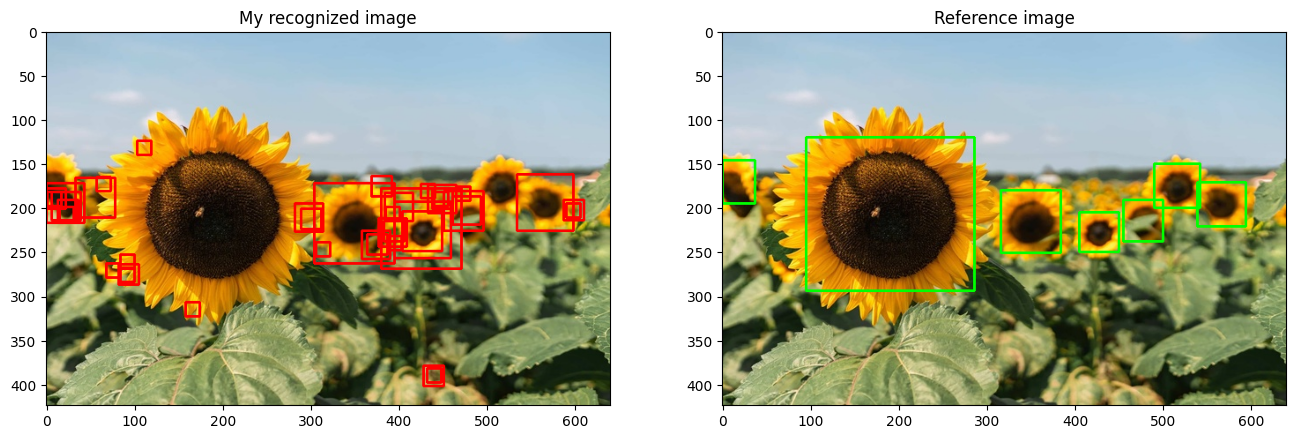

In [ ]:
VERBOSE = True
# ploting
recognition_color = (255, 0, 0)
reference_color = (0, 255, 0)
thickness = 2

# sigma range
sigma_min = 4

# blobing
divergence_threshold = 0.5

# load first file and visualize
for image, text_file in zip(imgs, files):

    # draw reference boxes 
    referece_img = image.copy()
    for box_coord in dict_files_boxes[text_file]:
        x1, y1 = box_coord[0]
        x2, y2 = box_coord[1]
        cv2.rectangle(referece_img, (x1, y1), (x2, y2), reference_color, thickness)
    
    # recognition
    blobs = []
    img_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sigma_max = int(min(image.shape[0], image.shape[1])/4)
    for sigma in genereta_sizes(sigma_min, sigma_max):
        #sigma = 16
        if VERBOSE:
            print("Sigma:", float(round(sigma, 2)))
        
        # LoG filter
        img_log = LoG_filter(img_gray, sigma)

        # Find local maxima
        min_distance = int(sigma)
        maxima = skimage.feature.peak_local_max(img_log, min_distance=min_distance)

        # Create list of blobs
        for y, x in maxima:
            blobs.append((x, y, sigma))
        
        if VERBOSE:
            print("Number of maximas:", len(maxima))
            #print("Number of blobs:", len(blobs))
        #break
    
    #blobs_filtered = blobs
    blobs_filtered = remove_unfiting_blobs_with_KL_div(image, blobs, img_template_hist_H, divergence_threshold)

    # draw recognized boxes
    recognized_img = image.copy()
    recognized_boxes = []
    print("Drawin", len(blobs_filtered) ,"of boxes.")
    for blob in blobs_filtered:
        box = convert_blob_to_box(blob)
        recognized_boxes.append(box)
        x1, y1 = box[0]
        x2, y2 = box[1]
        cv2.rectangle(recognized_img, (x1, y1), (x2, y2), recognition_color, thickness)
    
    # calculate stats
    precision, recall = precision_recall(recognized_boxes, dict_files_boxes[text_file])

    # print stats
    print("Stats:")
    print(" - Precision:", float(round(precision, 2)))
    print(" - Recall:", float(round(recall, 2)))

    # plot pictures
    print(image.shape)
    plt.figure(figsize=(16, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(recognized_img)
    plt.title("My recognized image")
    plt.subplot(1, 2, 2)
    plt.imshow(referece_img)
    plt.title("Reference image")
    break

## Vykreslení na všech obrázcích

0.70859194
1.1845423
1.9423898
2.398777
2.2709107
1.6255407
0.5214541
1.9843181
0.563938
1.1089811
1.5124803
2.6740973
0.55174804
2.4839406
2.8283935
0.49333197
0.72262883
1.0101322
2.517257
1.8144009
4.070038
2.9341676
3.9174223
0.8815906
1.2270027
1.087106
2.3147187
2.8853493
1.9431052
2.6964378
0.6946782
0.6884001
0.6315893
1.5257617
1.7332996
3.1475444
0.8458195
0.6872671
3.7115765
2.0833738
2.0766237
7.507468
3.0071535
2.6714714
1.3269494
0.88506335
2.7536845
3.2703755
2.2234235
8.132614
1.1445789
0.8278395
0.9875862
2.9913354
1.2196755
3.3947601
4.0682735
2.344091
5.9836445
6.134678
5.1311674
1.4680195
1.10626
3.5412178
0.7430996
3.2464294
3.060992
3.663156
8.029629
5.549926
3.6264038
2.324977
2.6596677
2.4105287
2.4287858
2.0607405
1.4542038
2.2828298
1.6911244
2.9358785
1.508198
1.6433563
7.6489
0.68561906
1.6919119
3.7934723
3.7581482
2.5437853
0.659241
2.510089
1.5656006
1.4815284
1.1235876
1.3521276
1.8364458
4.031865
3.0006819
2.7026594
3.93228
1.7774372
8.521252
1.27649
1.

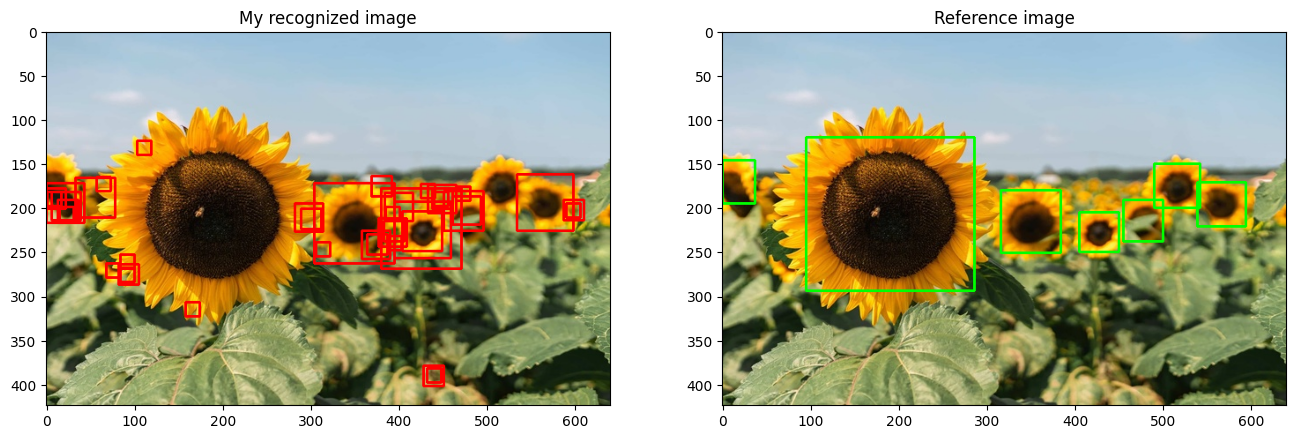

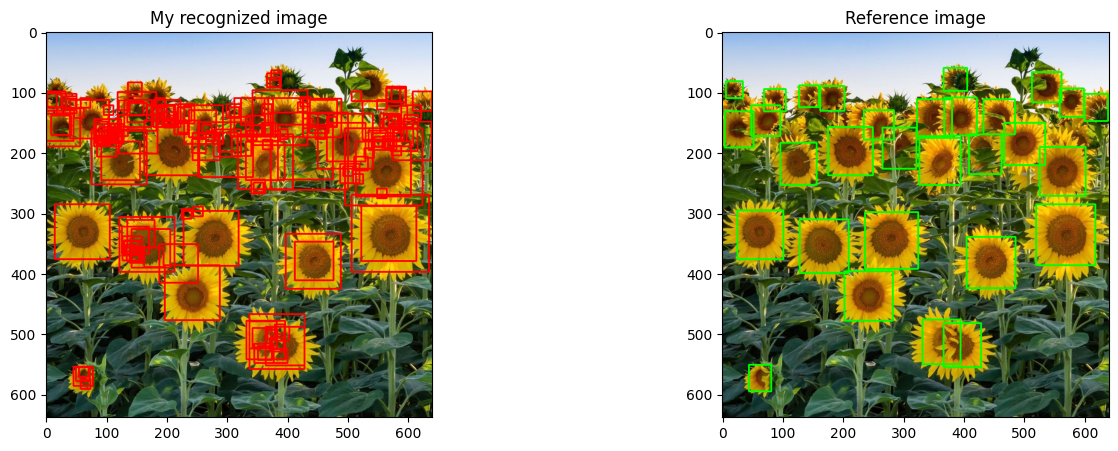

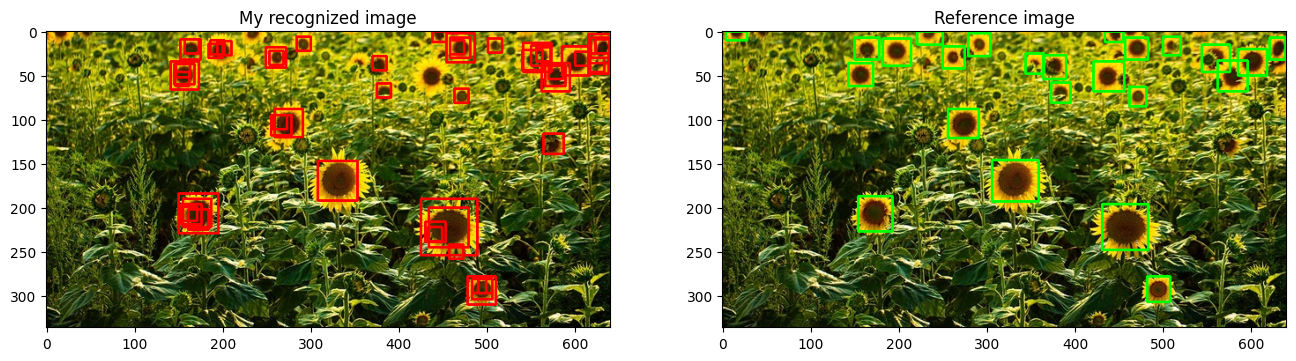

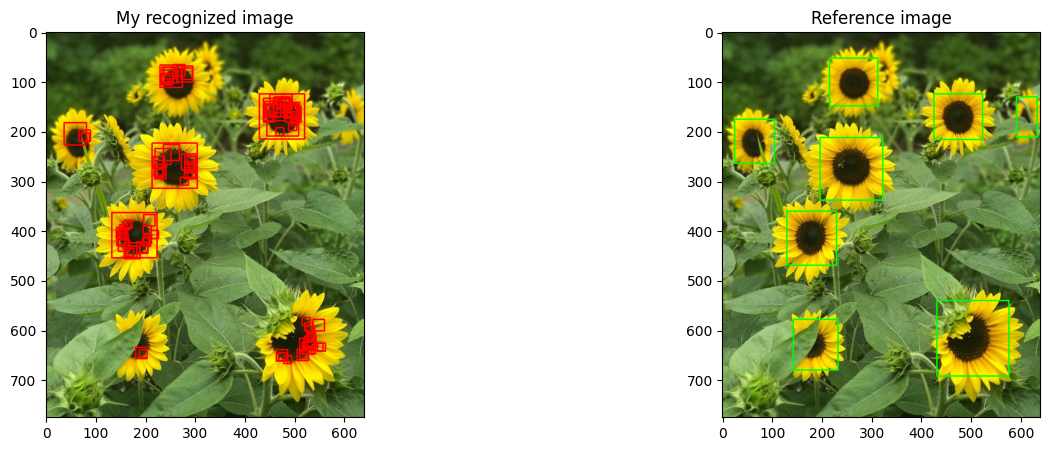

In [59]:
VERBOSE = False
# ploting
recognition_color = (255, 0, 0)
reference_color = (0, 255, 0)
thickness = 2

# sigma range
sigma_min = 4

# blobing
divergence_threshold = 0.5

# load first file and visualize
for image, text_file in zip(imgs, files):

    # draw reference boxes 
    referece_img = image.copy()
    for box_coord in dict_files_boxes[text_file]:
        x1, y1 = box_coord[0]
        x2, y2 = box_coord[1]
        cv2.rectangle(referece_img, (x1, y1), (x2, y2), reference_color, thickness)
    
    # recognition
    blobs = []
    img_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    sigma_max = int(min(image.shape[0], image.shape[1])/4)
    for sigma in genereta_sizes(sigma_min, sigma_max):
        #sigma = 16
        if VERBOSE:
            print("Sigma:", float(round(sigma, 2)))
        
        # LoG filter
        img_log = LoG_filter(img_gray, sigma)

        # Find local maxima
        min_distance = int(sigma)
        maxima = skimage.feature.peak_local_max(img_log, min_distance=min_distance)

        # Create list of blobs
        for y, x in maxima:
            blobs.append((x, y, sigma))
        
        if VERBOSE:
            print("Number of maximas:", len(maxima))
            #print("Number of blobs:", len(blobs))
        #break
    
    #blobs_filtered = blobs
    blobs_filtered = remove_unfiting_blobs_with_KL_div(image, blobs, img_template_hist_H, divergence_threshold)

    # draw recognized boxes
    recognized_img = image.copy()
    recognized_boxes = []
    print("Drawin", len(blobs_filtered) ,"of boxes.")
    for blob in blobs_filtered:
        box = convert_blob_to_box(blob)
        recognized_boxes.append(box)
        x1, y1 = box[0]
        x2, y2 = box[1]
        cv2.rectangle(recognized_img, (x1, y1), (x2, y2), recognition_color, thickness)
    
    # calculate stats
    precision, recall = precision_recall(recognized_boxes, dict_files_boxes[text_file])

    # print stats
    print("Stats:")
    print(" - Precision:", float(round(precision, 2)))
    print(" - Recall:", float(round(recall, 2)))

    # plot pictures
    print(image.shape)
    plt.figure(figsize=(16, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(recognized_img)
    plt.title("My recognized image")
    plt.subplot(1, 2, 2)
    plt.imshow(referece_img)
    plt.title("Reference image")
    #break